Oceans cover two-thirds of the planet. In this assignment, you will build a classifier to tell several types of creatures apart.

In [5]:
import os

from collections import Counter
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

Prepare the Environment
Task 1.5.1:

Get the GPU device, if it is available. Store the device name in the variable device.

In [7]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


Load the Data
The data for this assignment is contained in the directory sea_creatures. In this directory, there are two folders. We'll use train to train our classification model, and then submit predictions about the test images to the grader.

In [8]:
os.listdir("sea_creatures")

['test', 'train']

Task 1.5.2:

Find the names of the classes we will be working with. Images for each class are inside folders within the sea_creatures/train folder. Make a list of the class names (each corresponding to a directory name). Your list should be named classes.

In [9]:
train_dir = 'sea_creatures/train'
classes = os.listdir(train_dir)

print(classes)

['Dolphin', 'Jelly Fish', 'Octopus', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Sharks', 'Turtle_Tortoise', 'Whale']


Task 1.5.3:

Build a transformer pipeline. It should ensure the images are in RGB format, scale them to 224
224 pixels, and convert them into a PyTorch tensor. You will probably find ConvertToRGB useful.

In [10]:
height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Task 1.5.4:

Test that the transformer pipeline is working. Load in the specified training image and transform it. Check that you get a 3
224
224 tensor.

In [11]:
sample_file = "sea_creatures/train/Dolphin/10004986625_0f786ab86b_b.jpg"

image = Image.open(sample_file)

transformed_image = transform(image)
print(transformed_image.shape)

torch.Size([3, 224, 224])


Task 1.5.5:

Create a DataSet for the training data (using the ImageFolder subclass). It should apply the transformer pipeline.

In [12]:
dataset = datasets.ImageFolder(root='sea_creatures/train', transform=transform)
print("Image size", dataset[0][0].shape)
print("Label", dataset[0][1])

Image size torch.Size([3, 224, 224])
Label 0


Task 1.5.6:

Calculate the class distribution. Store this in the variable class_distribution as a dictionary. The keys should be the class names. The values should be the number of training samples for the class.

In [13]:
from collections import Counter
from tqdm import tqdm

counts = Counter(x[1] for x in tqdm(dataset))
print("The counts dictionary:", counts)

# This dictionary maps class names to their index.
print("The class_to_idx dictionary:", dataset.class_to_idx)

# Use both of these to construct the desired dictionary

class_distribution = {class_name: counts[class_idx] for class_name, class_idx in dataset.class_to_idx.items()}
print(class_distribution)

100%|██████████| 6182/6182 [02:13<00:00, 46.48it/s]

The counts dictionary: Counter({7: 1716, 1: 752, 0: 711, 6: 533, 5: 524, 8: 512, 2: 495, 3: 488, 4: 451})
The class_to_idx dictionary: {'Dolphin': 0, 'Jelly Fish': 1, 'Octopus': 2, 'Puffers': 3, 'Sea Rays': 4, 'Sea Urchins': 5, 'Sharks': 6, 'Turtle_Tortoise': 7, 'Whale': 8}
{'Dolphin': 711, 'Jelly Fish': 752, 'Octopus': 495, 'Puffers': 488, 'Sea Rays': 451, 'Sea Urchins': 524, 'Sharks': 533, 'Turtle_Tortoise': 1716, 'Whale': 512}


Transform the Data
Task 1.5.7:

Create a DataLoader that loads from this DataSet in batches of 32.

In [14]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


Task 1.5.8: Calculate the mean and standard deviation of each channel in this data set.

Fill the missing lines in the get_mean_std function and invoke it with the right dataset.

This will calculate the correct values for mean and std.

In [15]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    # Compute the mean from the channels_sum and num_batches
    mean = channels_sum / num_batches
    # Compute the standard deviation form channels_squared_sum, num_batches,
    # and the mean.
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std


mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

100%|██████████| 194/194 [00:18<00:00, 10.27it/s]

Mean: tensor([0.2992, 0.4125, 0.4588])
Standard deviation: tensor([0.2697, 0.2404, 0.2658])


Task 1.5.9:

Build a new transformer pipeline that normalizes the channels according to the mean and standard deviation above. The pipeline should be assigned to the variable transform_norm. Afterwards, use the pipeline to create a normalized data set and store it in the variable norm_dataset.

In [17]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)
print(transform_norm)

norm_dataset = datasets.ImageFolder(root=train_dir,transform=transform_norm)
norm_loader =DataLoader(dataset=norm_dataset,batch_size=32)
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")
print("Image size", norm_dataset[0][0].shape)
print("Label", norm_dataset[0][1])

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.2992, 0.4125, 0.4588]), std=tensor([0.2697, 0.2404, 0.2658]))
)


100%|██████████| 194/194 [00:20<00:00,  9.28it/s]

Mean: tensor([1.0254e-07, 4.2877e-07, 3.8482e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])
Image size torch.Size([3, 224, 224])
Label 0


Task 1.5.10:

Split the normalized data set into a training set and a validation set. 80% of the data should be in the training set, and 20% in the validation set.

In [18]:
train_dataset, val_dataset = random_split(norm_dataset,[0.8,0.2])

print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

Training data set size: 4946
Validation data set size: 1236


Task 1.5.11:

Set up data loaders for both the training and validation data sets. Use the same batch size as before. Remember to set shuffle=True on the training loader.

In [19]:
train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size = batch_size)

Build the Model
Task 1.5.12:

Start setting up the network. We'll begin with three layers:

2D convolution with sixteen 3x3 kernels
ReLU activation
Max pooling with 4x4 kernels (and a stride of 4x4)

In [20]:
torch.manual_seed(42)
model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
max_pool1 = torch.nn.MaxPool2d(4)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 16, 56, 56]          --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
Total params: 448
Trainable params: 448
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 719.32
Input size (MB): 19.27
Forward/backward pass size (MB): 205.52
Params size (MB): 0.00
Estimated Total Size (MB): 224.79

Task 1.5.13: Add three more layers to the network.

2D convolution with thirty-two  3x3 kernels
ReLU activation
Max pooling with 4x4 kernels

In [21]:
conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
max_pool2 = torch.nn.MaxPool2d(4)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 32, 14, 14]          --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.18
Input size (MB): 19.27
Forward/backward pass size (MB): 231.21
Params size (MB): 0.02
Estimated Total Size (MB): 250.50

Task 1.5.14: Add four more layers to the network.

2D convolution with sixty-four 3x3 kernels
ReLU activation
Max pooling with 4x4 kernels
Flattening

In [22]:
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(4)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)
model.append(torch.nn.Flatten())

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 576]                 --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.30
Input size (MB): 19.27
Forward/backwa

ask 1.5.15: Add the final layers to the model

Drop-out (with P=0.5)
Linear layer with 500 outputs (check the summary above to get the correct number of inputs)
ReLU activation
Drop-out
Linear output layer with the appropriate number of output

In [23]:
model.append(torch.nn.Dropout(p=0.5))
Linear = torch.nn.Linear(in_features=576, out_features=500)
model.append(Linear)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout(p=0.5))
Linear = torch.nn.Linear(500, 9)
model.append(Linear)

height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 9]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─

Task 1.5.16:

Prepare for training. Define the loss function, create an optimizers, and send the model to the GPU device.

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Task 1.5.17:

Train model for 10 epochs.

In [ ]:
from training import train, predict  # Import functions

# Define the number of epochs
num_epochs = 10  

# Run training
train(model,optimizer,loss_fn,train_loader,val_loader,epochs=10,device=device)

Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 1.68, Validation Loss: 1.48, Validation accuracy = 0.50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 1.41, Validation Loss: 1.36, Validation accuracy = 0.50


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 1.32, Validation Loss: 1.25, Validation accuracy = 0.56


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 1.25, Validation Loss: 1.19, Validation accuracy = 0.60


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 1.21, Validation Loss: 1.17, Validation accuracy = 0.59


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 1.18, Validation Loss: 1.17, Validation accuracy = 0.59


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 1.13, Validation Loss: 1.19, Validation accuracy = 0.60


Training:   0%|          | 0/155 [00:00<?, ?it/s]

Scoring:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 1.10, Validation Loss: 1.04, Validation accuracy = 0.64


Evaluate the Model Performance
Task 1.5.18:

Make predictions for all of the images in the validation set. Start by calculating the probabilities using the predict function (from our training.py module). And then calculate the predicted class based in the probabilities.

In [26]:
# Compute the probabilities for each validation image
probabilities = predict(model,val_loader,device)

# Get the index associated with the largest probability for each
predictions = torch.argmax(probabilities,dim=1)

print("Number of predictions:", predictions.shape)

Predicting:   0%|          | 0/39 [00:00<?, ?it/s]

Number of predictions: torch.Size([1236])


Task 1.5.19:

Create the confusion matrix for the predictions on the validation set. We have provided the actual classes in the targets variable.

100%|██████████| 39/39 [00:04<00:00,  8.00it/s]


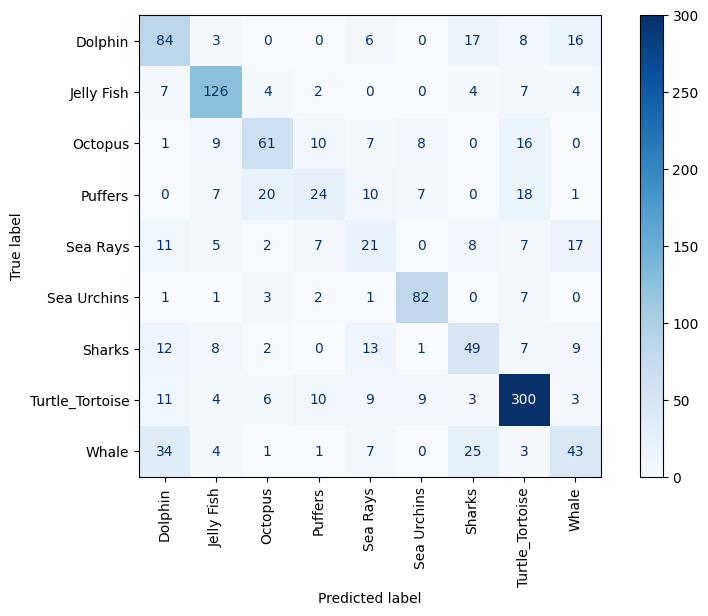

In [27]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

    # Don't change this
fig, ax = plt.subplots(figsize=(10, 6))

cm = confusion_matrix(targets,predictions.cpu())

# Get the class names
classes = os.listdir(train_dir)

# Display the confusion matrix (don't change this)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)

Task 1.5.20:

Create a data set for the test data. It is located in the sea_creatures/test directory. Then create a data loader from this data set. DO NOT shuffle this data!

In [28]:
test_dir = "sea_creatures/test"
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create the test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

print("Number of test images:", len(test_dataset))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Number of test images: 699


Task 1.5.21: Make a prediction for each of the test images.

In [29]:
import torch

# Ensure the model is in evaluation mode
model.eval()

# Store probabilities and predictions
test_probabilities = []
test_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)  # Move images to the correct device (CPU/GPU)
        
        # Get model predictions (probabilities after softmax)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        
        # Get the index of the highest probability class
        predicted_classes = torch.argmax(probabilities, dim=1)
        
        test_probabilities.append(probabilities.cpu())  # Store on CPU
        test_predictions.append(predicted_classes.cpu())

# Concatenate the lists into tensors
test_probabilities = torch.cat(test_probabilities, dim=0)
test_predictions = torch.cat(test_predictions, dim=0)

print("Number of predictions:", test_predictions.shape[0])

Number of predictions: 699


Task 1.5.22: Convert the class index to the class name for each test image.

In [30]:
test_classes = [classes[i] for i in test_predictions]

print("Number of class predictions:", len(test_classes))

Number of class predictions: 699


Final checks
You can now check how accurate your model is by sampling some images from our /test directory. These images are not labled, so you'll need to check it manually.

The code below randomly samples 12 images from the test directory and shows them in a grid alongside its predicted label. Run it as many times as you want to get different samples.

How is it working?

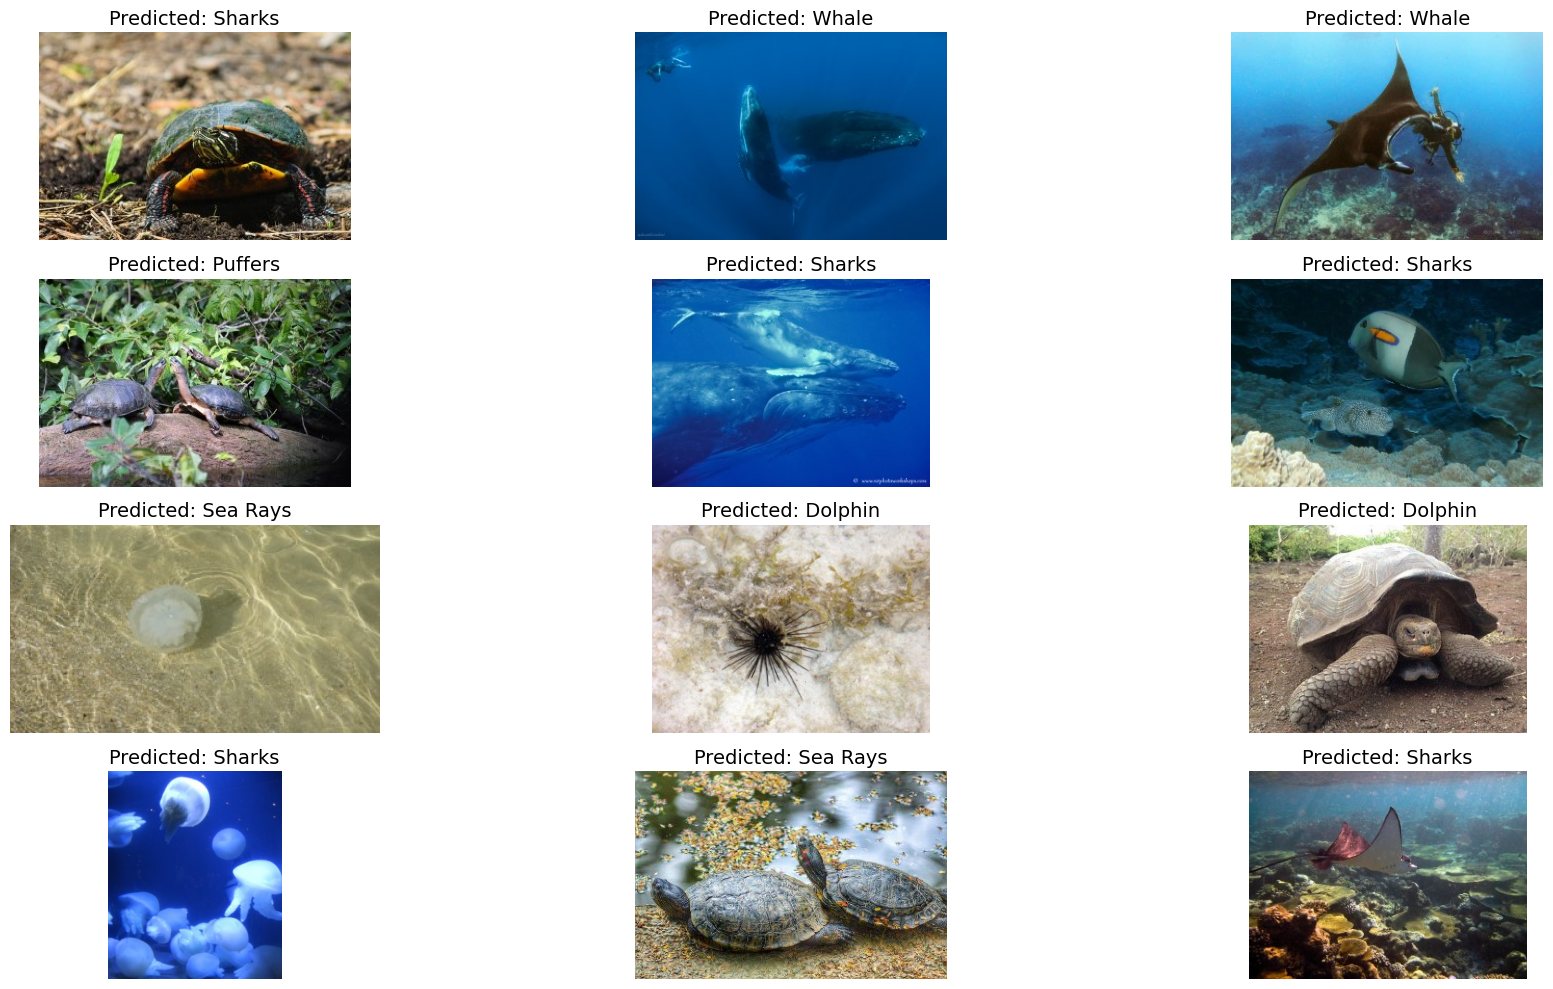

In [32]:
import matplotlib.pyplot as plt
import random

# Sample 12 random indices from the test dataset
sample_indices = random.sample(range(len(test_loader.dataset.samples)), 12)

# Create a grid of 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 10))

# Iterate over the sampled indices and plot the corresponding images
for ax, idx in zip(axes.flatten(), sample_indices):
    image_path = test_loader.dataset.samples[idx][0]
    img = Image.open(image_path)

    # Display the image on the axis
    ax.imshow(img)
    ax.axis('off')

    # Get the predicted class for this image
    predicted_class = test_classes[idx]

    # Set the title of the subplot to the predicted class
    ax.set_title(f"Predicted: {predicted_class}", fontsize=14)

plt.tight_layout()